<a href="https://colab.research.google.com/github/anuka0407/Unsupervised-Learning---credit_risk_tolerance-/blob/main/UNSUPERVISED_LEARNING_CAPSTONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Investors Based on the data of 2019 Survey of Consumer Finance**

#  **1. Project Goal**


> **The goal of this case study is to build a ML model to cluster investors based on the parameters related to their ability and willingness to take risk focusing on some common demographic and financial characteristics.**


#  **2. Load Data & Python Libraries**

* This dataset was obtained on https://www.federalreserve.gov/econres/scfindex.htm website and contains 2019 Survey of Consumer Finances (SCF).

* Please see the attached CSV file for convenience: https://drive.google.com/file/d/1y-4bczIBaoq4flUIL4c9AAlib_-6A05r/view?usp=drive_link



In [ ]:
from logging import warning
#Load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


#disable warings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load data
data_path="/content/drive/MyDrive/Thinkful Data Science Projects/SCFP2019.csv"
df=pd.read_csv(data_path)

In [ ]:
df.head(10)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
5,2,21,3790.476607,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
6,2,22,3798.868505,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,3,2,2
7,2,23,3799.468393,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
8,2,24,3788.076005,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2
9,2,25,3793.066589,1,50,3,8,2,1,3,...,1,2,1,2,1,1,4,4,2,2


In [ ]:
df.shape

(28885, 351)

#  **3. Data Exploration & Feauture Selection**

Initial dataset above contains 351 variables, such as households' demographics, net worth, financial, non-financial assets, self-assessments on risk tolerance & financial knowledge, etc.

For this clustering capstone, I selected the most intuitive variables and followed the codebooks provided on the SCF website.

Codebooks for this survey can be found here:

* https://www.federalreserve.gov/econres/files/codebk2019.txt
*  https://www.federalreserve.gov/econres/files/bulletin.macro.txt



---

The description of the selected feautures is as follows:

---



*   `AGECL`: There are 6 age categories, where 1 represents age less than 35 and 6 represents age more than 75. 1:<35, 2:35-44, 3:45-54, 4:55-64, 5:65-74, 6:>=75;
* `EDCL`: What is the highest level of school completed -  1=no high school diploma/GED, 2=high school diploma or GED, 3=some college or Assoc. degree, 4=Bachelors degree or higher;
* `MARRIED`: It represents marital status. There are two categories where 1 represents married and 2 represents unmarried.
* `OCCAT2` : It represents occupation category. 1=managerial/professional 2=technical/sales/services, 3=other (incl. production/craft/repair workers, operators,laborers, farmers, foresters, fishers) 4=not working;
* `KIDS`: It represents number of kids.
* `NWCAT`: It represents net worth category. There are 5 categories, where 1 net worth less than 25 percentile and 5 represents net worth more than 90th percentile.
* `INCCL2`***: It represents income category (encoded while data prepping below) If income is less than 10000 then INCCL2=1 & if more than 100K then the value is 5.
* `HHOUSES`: have owned principal residence: 1=yes, 0=no;
* `HHSEX`: 1=male, 2=female
* `SPENDMOR`: If assets appreciated in value, person would spend more, 1=agree strongly, 2=agree somewhat, 3=neither agree nor disagree, 4=disagree somewhat, 5=disagree strongly;
* `KNOWL`: Knowledge about personal finances 1=not at all knowledgeable...10=vary knowledgeable;
* `HSAVINGS`: have some savings 1=yes, 0=no;
* `HASSET`: - have any assets: 1=yes, 0=no;
* `LEVRATIO`:
  If debt and assets are positive then LEVRATIO=(DEBT/ASSET);
  and if (DEBT > 0 & ASSET=0) then levratio is 1 and otehrwise 0 (note that in finance literature leverage ratio is best to be closest to 0 or less than 1)
* `YESFINRISK`: willing to take financial risk;
  
     




In [ ]:
Keep_cols=['AGECL', 'EDCL', 'MARRIED', 'OCCAT2', 'KIDS', 'NWCAT', 'INCOME', 'HHOUSES', 'HHSEX', 'SPENDMOR', 'KNOWL', 'HSAVING', 'HASSET', 'LEVRATIO', 'YESFINRISK']

drop_list = [col for col in df.columns if col not in Keep_cols]

df_clean=df.drop(labels=drop_list, axis=1)

In [ ]:
df_clean.shape


(28885, 15)

In [ ]:
df_clean.describe()


,HHSEX,AGECL,EDCL,MARRIED,KIDS,OCCAT2,INCOME,SPENDMOR,KNOWL,YESFINRISK,HSAVING,HHOUSES,HASSET,LEVRATIO,NWCAT
count,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,2.888500e+04,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000,28885.000000
mean,1.223819,3.388783,3.073394,1.375974,0.748312,2.311546,9.706635e+05,3.622434,7.388991,0.049680,0.514973,0.679765,0.996088,30.810805,3.075022
std,0.416809,1.546648,1.008865,0.484382,1.123829,1.238510,1.018805e+07,1.276217,2.177354,0.217286,0.499784,0.466575,0.062425,1386.356064,1.509840
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,2.000000,2.000000,1.000000,0.000000,1.000000,3.665224e+04,3.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,1.000000,3.000000,3.000000,1.000000,0.000000,2.000000,7.941320e+04,4.000000,8.000000,0.000000,1.000000,1.000000,1.000000,0.098258,3.000000
75%,1.000000,5.000000,4.000000,2.000000,1.000000,4.000000,1.995511e+05,5.000000,9.000000,0.000000,1.000000,1.000000,1.000000,0.444368,5.000000
max,2.000000,6.000000,4.000000,2.000000,7.000000,4.000000,7.035907e+08,5.000000,10.000000,1.000000,1.000000,1.000000,1.000000,78000.000000,5.000000


## **Initial Observations**

* Note that INCOME needs to be encoded based on the codebook description above (in the initial dataset, encoded variable is missing so I'll do this myself below)

* LEVRATIO seems to be suffering from extreme outliers, as mean is ~ 30 while max value is 78000. I will be focusing on cleaning this up in data prep below.

In [ ]:
df_clean.head()


,HHSEX,AGECL,EDCL,MARRIED,KIDS,OCCAT2,INCOME,SPENDMOR,KNOWL,YESFINRISK,HSAVING,HHOUSES,HASSET,LEVRATIO,NWCAT
0,2,6,4,2,0,1,67195.781504,4,6,0,0,1,1,0.0,5
1,2,6,4,2,0,1,57014.602488,4,6,0,0,1,1,0.0,5
2,2,6,4,2,0,1,51924.012980,4,6,0,0,1,1,0.0,5
3,2,6,4,2,0,1,41742.833964,4,6,0,0,1,1,0.0,5
4,2,6,4,2,0,1,50905.895078,4,6,0,0,1,1,0.0,5


# **4. Data Preparation & Visualization**

**Note: There are 72 values that have LEVRATIO of more than 200, which seem extreme based on the given data.


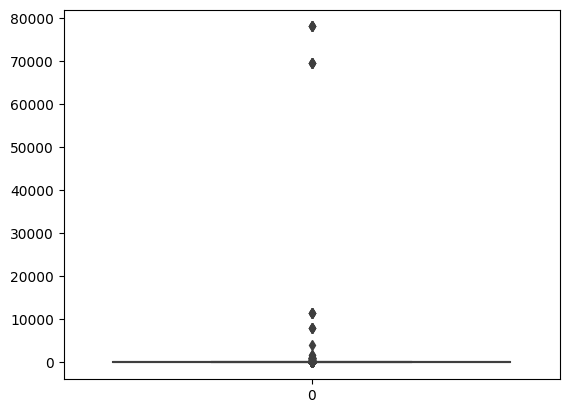

In [ ]:
#inspect outliers in LEVRATIO col

sns.boxplot(df_clean['LEVRATIO'])

extreme_values=df_clean[df_clean['LEVRATIO']>=200]
print('**Note: There are {} values that have LEVRATIO of more than 200, which seem extreme based on the given data.'.format(len(extreme_values)))


In [ ]:
# Filter the DataFrame to drop rows with extreme values in the levratio column
filtered_df = df_clean.drop(df_clean[df_clean['LEVRATIO']>=200].index)

# Print the resulting DataFrame after dropping the rows with extreme levratio
filtered_df.describe()

#Checking for any null values and removing the null values'''
print('Null Values =',filtered_df.isnull().values.any())

Null Values = False


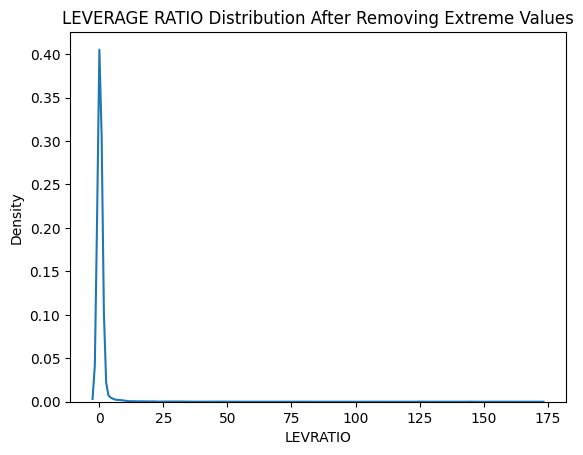

**Note: While extreme outliers were removed, we still notice that LEVRATIO on average ranges from 0 to 5 which agrees with the finance literature; Values of 25 and above are still somewhat outliers, but I will leave them for now.


In [ ]:
sns.kdeplot(filtered_df['LEVRATIO'])
plt.title("LEVERAGE RATIO Distribution After Removing Extreme Values")

plt.show()

print("**Note: While extreme outliers were removed, we still notice that LEVRATIO on average ranges from 0 to 5 which agrees with the finance literature; Values of 25 and above are still somewhat outliers, but I will leave them for now.")

In [ ]:
# encode INCOME

def INCCAT(INCOME):
  if INCOME < 10000:
    return '1'
  elif INCOME >= 10000 and INCOME < 25000:
    return '2'
  elif INCOME >=25000 and INCOME < 50000:
    return '3'
  elif INCOME >=50000 and INCOME < 100000:
    return '4'
  else:
    return '5'

filtered_df['INCCL2']=filtered_df['INCOME'].apply(INCCAT)


#drop nominal income values
filtered_df.drop(['INCOME'], 1, inplace=True)



In [ ]:
filtered_df.info()

print(filtered_df.INCCL2.value_counts())

filtered_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28813 entries, 0 to 28884
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HHSEX       28813 non-null  int64  
 1   AGECL       28813 non-null  int64  
 2   EDCL        28813 non-null  int64  
 3   MARRIED     28813 non-null  int64  
 4   KIDS        28813 non-null  int64  
 5   OCCAT2      28813 non-null  int64  
 6   SPENDMOR    28813 non-null  int64  
 7   KNOWL       28813 non-null  int64  
 8   YESFINRISK  28813 non-null  int64  
 9   HSAVING     28813 non-null  int64  
 10  HHOUSES     28813 non-null  int64  
 11  HASSET      28813 non-null  int64  
 12  LEVRATIO    28813 non-null  float64
 13  NWCAT       28813 non-null  int64  
 14  INCCL2      28813 non-null  object 
dtypes: float64(1), int64(13), object(1)
memory usage: 3.5+ MB
5    12253
4     6607
3     5562
2     3368
1     1023
Name: INCCL2, dtype: int64


,HHSEX,AGECL,EDCL,MARRIED,KIDS,OCCAT2,SPENDMOR,KNOWL,YESFINRISK,HSAVING,HHOUSES,HASSET,LEVRATIO,NWCAT,INCCL2
0,2,6,4,2,0,1,4,6,0,0,1,1,0.0,5,4
1,2,6,4,2,0,1,4,6,0,0,1,1,0.0,5,4
2,2,6,4,2,0,1,4,6,0,0,1,1,0.0,5,4
3,2,6,4,2,0,1,4,6,0,0,1,1,0.0,5,3
4,2,6,4,2,0,1,4,6,0,0,1,1,0.0,5,4


In [ ]:
#convert INCCL 2 object  to float

filtered_df['INCCL2']=filtered_df['INCCL2'].astype(float)
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28813 entries, 0 to 28884
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HHSEX       28813 non-null  int64  
 1   AGECL       28813 non-null  int64  
 2   EDCL        28813 non-null  int64  
 3   MARRIED     28813 non-null  int64  
 4   KIDS        28813 non-null  int64  
 5   OCCAT2      28813 non-null  int64  
 6   SPENDMOR    28813 non-null  int64  
 7   KNOWL       28813 non-null  int64  
 8   YESFINRISK  28813 non-null  int64  
 9   HSAVING     28813 non-null  int64  
 10  HHOUSES     28813 non-null  int64  
 11  HASSET      28813 non-null  int64  
 12  LEVRATIO    28813 non-null  float64
 13  NWCAT       28813 non-null  int64  
 14  INCCL2      28813 non-null  float64
dtypes: float64(2), int64(13)
memory usage: 3.5 MB


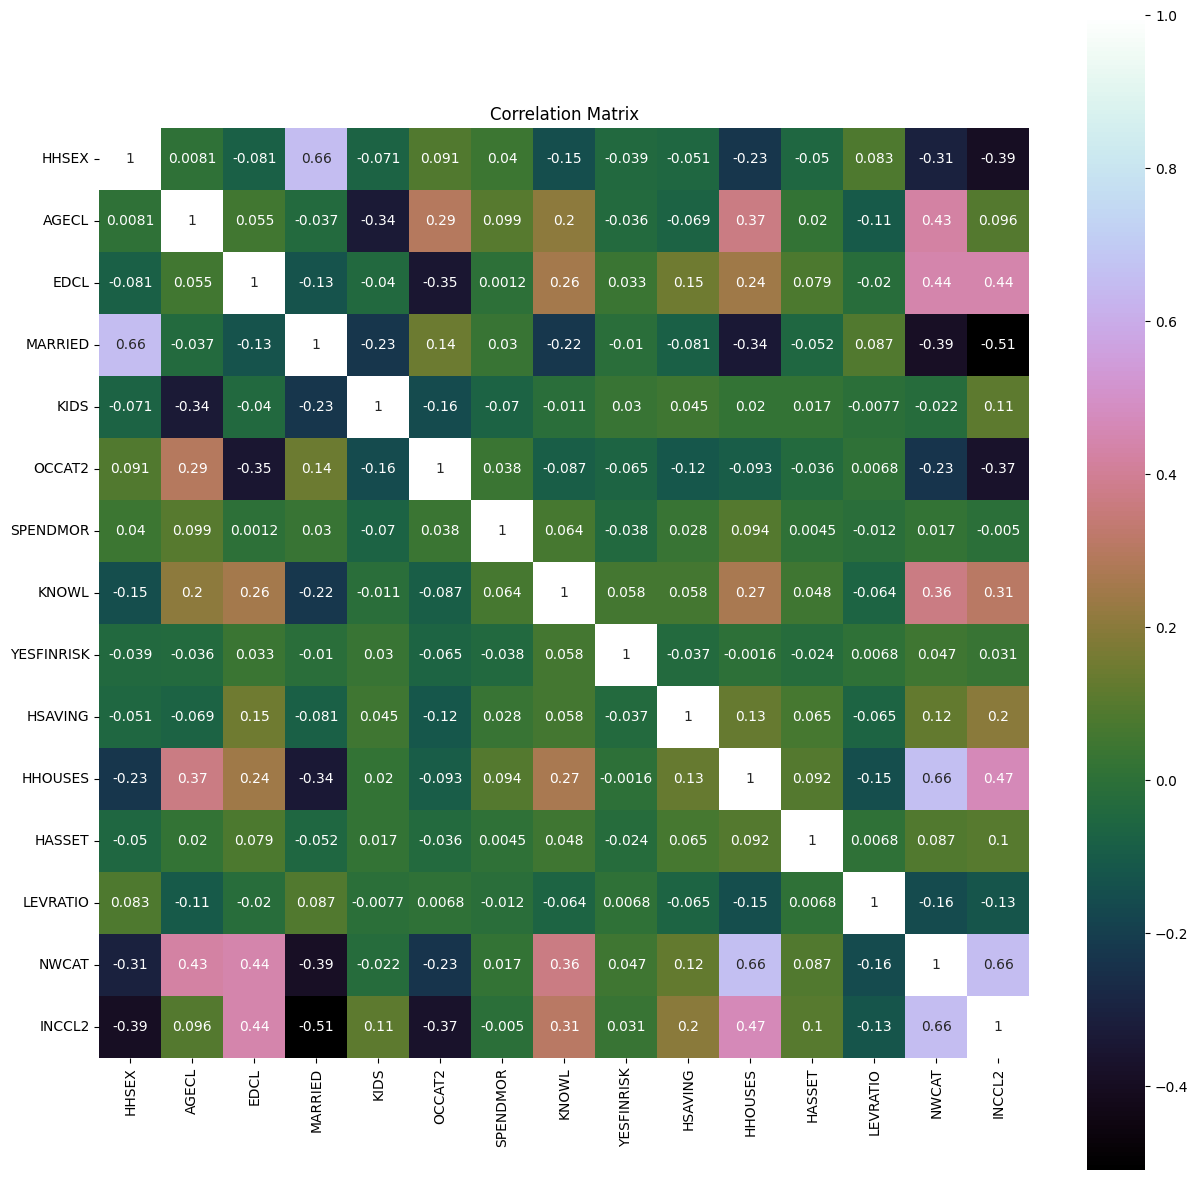

In [ ]:
# explore correlation.

corr=filtered_df.corr()
plt.figure(figsize=(15,15))
plt.title("Correlation Matrix")

sns.heatmap(corr, vmax=1, square=True, annot=True, cmap='cubehelix')

plt.show()

# **5. Evaluating Algorithms and Models**

In this step, I will look at the following models and perform further analysis and visualizations.

- K-Means
- DBSCAN


In [ ]:
#standardize the feautures (note most variables were in similar scale but levratio was not)
scaler=StandardScaler()
X_std=scaler.fit_transform(filtered_df)


## 5.1 **K-Means**

There are several methods to evaluate the best initial number of clusters in k-means. Some of the most common ones which I will be using are:
* `Elbow Method` - this method calculates the sum of squared distances between each data point and its nearest centroid for different values of k. Where the rate of decarese is sharp and forms an 'elbow' indicates the optimal number of clusters.
* `Silhouette Score` -  SS measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 to +1, where higher score indicates a better defined cluster.


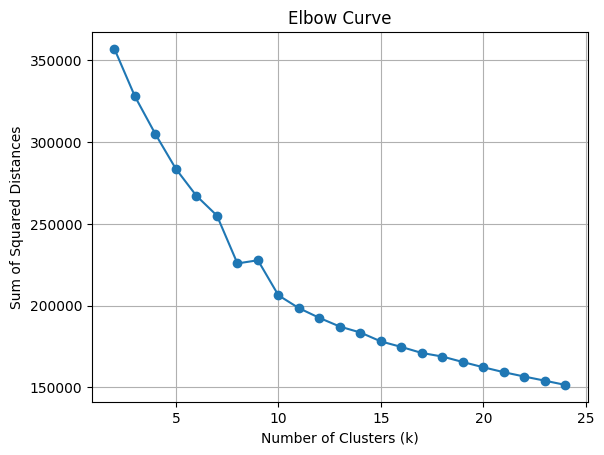

In [ ]:
## calculate sum of squared distances for different values of k

sse=[]

for k in range(2,25):
  kmeans=KMeans(n_clusters=k, random_state=123)
  kmeans.fit(X_std)
  sse.append(kmeans.inertia_)

#plot the elbow curve
plt.plot(range(2, 25), sse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Sum of Squared Distances")
plt.title("Elbow Curve")
plt.grid(True)

plt.show()

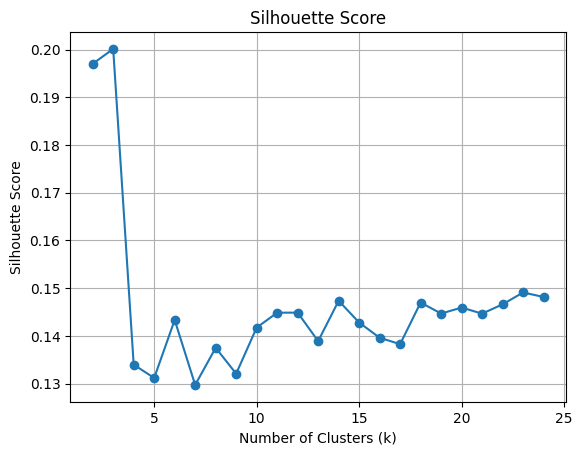

In [ ]:
## silhouette score

silhouette_scores=[]

for k in range (2, 25):
  kmeans=KMeans(n_clusters=k, random_state=123)
  labels=kmeans.fit_predict(X_std)
  score=silhouette_score(X_std, labels, random_state=123)
  silhouette_scores.append(score)

# Plot the silhouette scores
plt.plot(range(2, 25), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.grid(True)
plt.show()

Based on the Elbow Chart, we can see that the optimal number of clusters seem to be between 7 and 10. Once K passes 10, the elbow curve plateaus off.

From the Silhouette graph, it's harder to infer the trend but from K=10, the trend is actually more upward movement. We see the biggest spike from K=6 to K=7.

Combining the informatin from both graphs, I'll run K-Means algorithm with K=7, 8 and 9 clusters and evaluate the performance.

### **Clustering with K-Means**


In [ ]:
# k means clustering with k=7, 8, 9

cluster_numbers=[7, 8, 9]

kmeans_clusters=[]

for i in cluster_numbers:
  k_means=KMeans(n_clusters=i, random_state=123)
  kmeans_clusters.append(k_means.fit_predict(X_std))

### **Cluster Evaluation with K-Means**

In [ ]:
#silhouette scores for each cluster K=7,8,9

for i, j in enumerate(kmeans_clusters):
  print("Silhoueette score for K-means with k={} is {} ".format(cluster_numbers[i], metrics.silhouette_score(X_std, j, metric='euclidean')))

Silhoueette score for K-means with k=7 is 0.1297076349052736 
Silhoueette score for K-means with k=8 is 0.13748862881591137 
Silhoueette score for K-means with k=9 is 0.1320639119510194 


Based on the Silhouette scores printed above, we see that K=8 has the highest score among 3 clusters with **SS=0.137**.

## **5.2 DBSCAN**

`Density-Based Spatial Clustering of Applications with Noise` as the name suggests is a density based algorithm that groups together data points based on their density.

Some of the pros of using DBSCAN for clustering are:
- No need to specify number of clusters unlike in K-Means clustering.
- Ability to work with clusters of arbitrary, complex shapes.
- Robust to noise & outliers.

However, there are some cons to be aware of as expected. Major ones are:

- Sensitive to parameter settings: DBSCAN has 2 important parameters - `epsilon` and `minimum points`. Selecting appropriate values are challenging and impacts the clusterings results
- Struggles with identifying clusters of significantly varying density since the algorithm depends on density of points to identify clusters.
- Computationally expensive as it calculates pairwise distances between points.



### **Clustering with DBSCAN**

In [ ]:
# Define a range of parameter values to search
param_grid = {'eps': [0.2, 0.5, 0.8, 1, 2, 3],
              'min_samples': [3, 5, 7, 9]}

best_score = -1
best_params = {}

# Perform cross-validation to find the best parameters
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    labels=dbscan.fit_predict(X_std)
    silhouette_avg=silhouette_score(X_std, labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params = params

# Fit DBSCAN with the best parameters
dbscan = DBSCAN(**best_params)
labels = dbscan.fit_predict(X_std)



### **Cluster Evaluation with DBSCAN**

In [ ]:
# Count the number of clusters (excluding noise points)
n_clusters = len(np.unique(labels)) - 1
print("With DBSCAN I ended up with {} Number of clusters.".format(n_clusters))

With DBSCAN I ended up with 5158 Number of clusters.


In [ ]:
# Evaluate the clustering
silhouette_avg = silhouette_score(X_std, labels, random_state=10)
print(f"Best Parameters: {best_params}")
print(f"Silhouette Score: {silhouette_avg}")

Best Parameters: {'eps': 0.2, 'min_samples': 3}
Silhouette Score: 0.9159014862487659


Silhouette score for DBSCAN with the parameters Eps=0.2 and min points of 3 is extremely high, especially compared to K-Means, with **SS=0.916**. I find this result a bit concerning, given the large number of clusters found with DBSCAN. Below I'll try to run DBSCAN model with different parameter values and re-evaluate the performance.

In [ ]:
# Define a range of parameter values to search
param_grid_v2 = {'eps': [0.1, 0.2, 0.4, 0.8, 1, 3, 5],
                 'min_samples': [2, 5, 10, 20]}

best_score = -1
best_params = {}

# Perform cross-validation to find the best parameters
for params in ParameterGrid(param_grid_v2):
    dbscan = DBSCAN(**params)
    labels=dbscan.fit_predict(X_std)
    silhouette_avg=silhouette_score(X_std, labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_params_v2 = params

# Fit DBSCAN with the best parameters
dbscan_v2 = DBSCAN(**best_params_v2)
labels_v2 = dbscan.fit_predict(X_std)

In [ ]:
# Count the number of clusters (excluding noise points)
n_clusters = len(np.unique(labels_v2)) - 1
print("With DBSCAN I ended up with {} Number of clusters.".format(n_clusters))

With DBSCAN I ended up with 3 Number of clusters.


In [ ]:
# Evaluate the clustering
silhouette_avg_v2 = silhouette_score(X_std, labels_v2, random_state=10)
print(f"Best Parameters: {best_params_v2}")
print(f"Silhouette Score: {silhouette_avg_v2}")

Best Parameters: {'eps': 0.4, 'min_samples': 2}
Silhouette Score: 0.708052727093823


I ran DBSCAN with multiple parameters and finally got a nicer result, Silhouette score did decrease from 0.9 t0 0.7 but number of clusters decreased significantly from around 5000 to only 3 as well.

> **I would choose DBSCAN with Epsilon of `o.4` and min_samples of `2` to be the best performing model for my dataset.**

# **6. Conclusion - Cluster Intuition with The Best Performing Model**

> In the final step, I will try to understand the intuitions behind the clusters of the best performing and the most optimal model, **which, in this case is DBSCAN with Eps of `0.4` and min_samples of `2`** giving me 3 clusters with the silhuette score of 0.71.

* Please note by utilizing the DBSCAN algorithm with an epsilon value of 0.3 &  a minimum sample size of 3, a highly impressive silhouette score of 0.9 was attained. However, this particular parameter combination also led to more than 5000 clusters. This level of granularity could be problematic to interpret and might not be a feasible option for segmenting consumer data depending on their risk preferences.

Below

* I will try to analyze clusters by examining data points within each cluster
* Visualize demographic and financial attributes of individuals within each specific cluster.

In [ ]:
# Create a DataFrame with the variables and cluster labels
cluster_df = pd.concat([pd.DataFrame(filtered_df), pd.DataFrame(labels_v2, columns=['Cluster'])], axis=1)

# Filter out the noise points (cluster -1)
filtered_cluster_df = cluster_df[cluster_df['Cluster'] != -1]

# Calculate the mean for each cluster
output = filtered_cluster_df.groupby('Cluster').mean()

# Print the output
output


,HHSEX,AGECL,EDCL,MARRIED,KIDS,OCCAT2,SPENDMOR,KNOWL,YESFINRISK,HSAVING,HHOUSES,HASSET,LEVRATIO,NWCAT,INCCL2
Cluster,,,,,,,,,,,,,,,
0.0,1.222712,3.395486,3.075871,1.373928,0.747717,2.309361,3.621977,7.392966,0.049554,0.516500,0.682100,0.996885,0.901832,3.083360,3.895853
1.0,1.300885,2.707965,2.575221,1.451327,0.787611,2.415929,3.513274,6.230088,0.053097,0.371681,0.451327,0.787611,1.663666,2.274336,3.256637
2.0,1.279070,2.860465,3.162791,1.651163,1.069767,1.860465,3.372093,7.279070,0.000000,0.418605,0.697674,1.000000,8.282250,2.837209,3.813953


## **6.1 Analyzing demographic features.**

<Axes: xlabel='Cluster'>

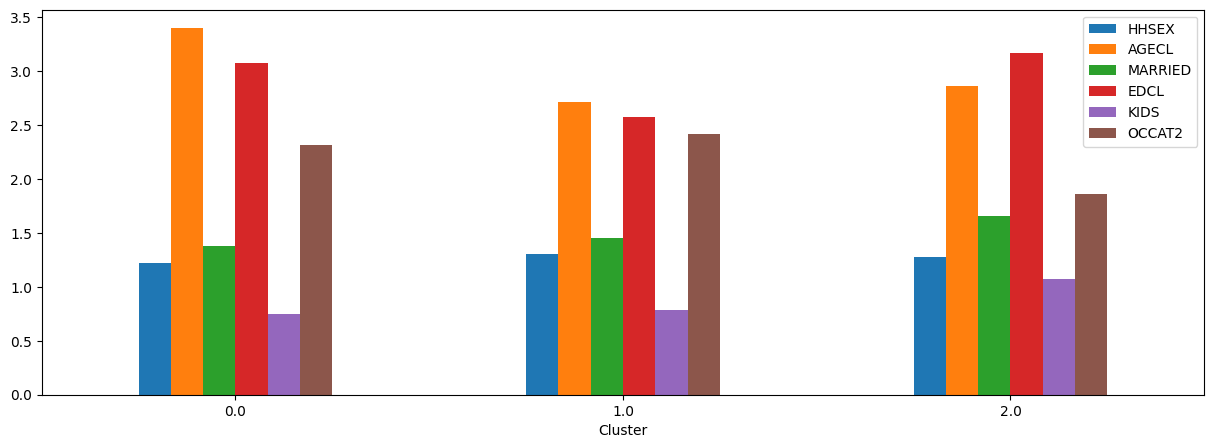

In [ ]:
output[['HHSEX', 'AGECL', 'MARRIED', 'EDCL', 'KIDS', 'OCCAT2', ]].plot.bar(rot=0, figsize=(15,5))

Plot here shows the average value of the attributes within each cluster.

*  For example comparing cluster 0 to 1, Cluster 1 has lower average age class than Cluster 0, higher average educational level. In terms of individuals' sex, marriage, number of kids and occupational category, those 2 clusters are almost identical.

* Cluster 2 observations stand in between Cluster 0 and 1 for Age category, has approximately similar education class as cluster 0 with more average kids, higher proportion of marriage  and lower occupational category (indicating managerial, technical service industries jobs rather than operations, laborerers, farmers, repair or not working) than both other clusters.



## **6.2 Analyzing financial features.**

<Axes: xlabel='Cluster'>

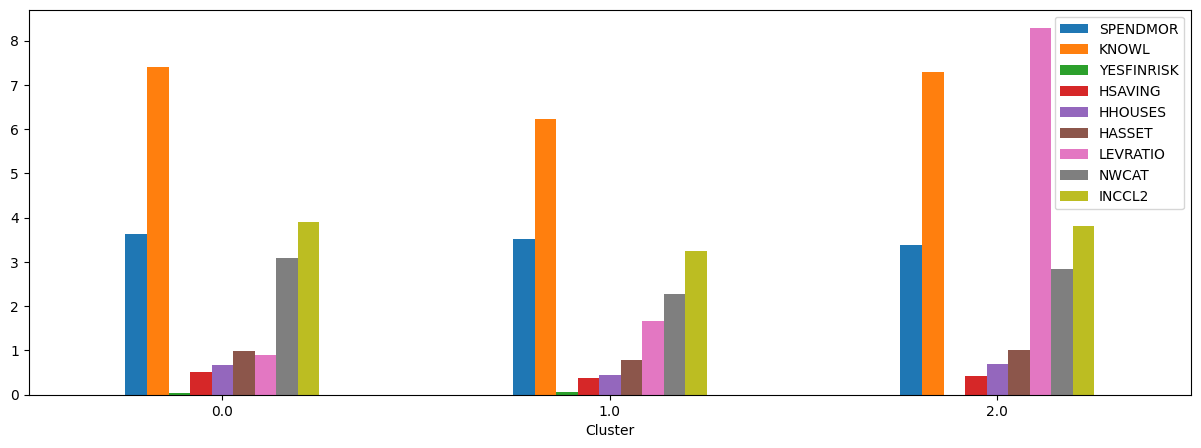

In [ ]:
output[['SPENDMOR', 'KNOWL', 'YESFINRISK', 'HSAVING', 'HHOUSES', 'HASSET', 'LEVRATIO', 'NWCAT', 'INCCL2']].plot.bar(rot=0, figsize=(15,5))


For financial attributes:
- Cluster 0 has higher proportion of observations with greater knowledge about personal finances, with higher income class, net worth, more savings, asset ownership, more house ownership compared to Cluster 1. Cluster 0 also has lower leverage ratio (lower debt to asset ratio) and lower risk tolerance on self assessment than cluster 1.

- Cluster 2 observations have knowledge about personal finances, income class, net worth, asset ownership, house wonership, and savingsattributes in between cluster 0 and 1, way higher leverage ratio than both clusters (higher debt to asset/income ratio) and almost no risk tolerance.


## **6.3 Final Notes**

Combining financial and demographic information presented above, I summerized the results below to evaluate the risk capacity of individuals within each cluster.

* **Cluster 0** | **Higher Age Class, Lower Education, Higher income class, net worth, more savings, home ownership, lower risk tolerance on self assessment** > Most likely well estabslihsed professionals in their 55-65 range, `low to medium risk appetite`.

*  **Cluster 1** | **Lower age group, higher educational level, lower knowledge of personal finances, lower income, net worth, higher leverage ratio, higher risk tolerance on self-assessment** > young generation, fresh out of school crowd with `high risk tolerance`.

* **Cluster 2** | **Medium age category (between Clusetr 0 and 1), similar education as Cluster 0,  with higher proportion of marriage and more kids with higher occupation roles (managerial, sales etc) with  high income class, net worth  & the higheest leverage ratio (already high dept), almost no risk tolerance on self-assessment** > Most likley professionals with young families, 35-55 range, `low to medium risk appetite`.

